In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

import os
import glob

from tqdm import tqdm 
# import required module
from pathlib import Path
import matplotlib.pyplot  as plt
import librosa
import librosa.display
%matplotlib inline
plt.style.use('seaborn')

In [3]:
def summarize_dataset(disease_name=None, root_path=None):

    male_counter = 0
    female_counter = 0

    if disease_name.lower() == "asthma":
        configfiles = pd.read_csv("asthma_audio_path.csv") 

        for p in tqdm(list(configfiles["astma_audio_path"])):

            file =  os.path.basename(p) ## Now get the file name with os.path.basename

            if file.startswith("cough") & file.endswith("-m.wav"):

                    if file.startswith("coughburst"):
                        continue
                    else:    
                        male_counter += 1

            elif file.startswith("cough") & file.endswith("-f.wav"):
                
                    if file.startswith("coughburst"):
                        continue
                    else:      
                        female_counter += 1                
    else:
        for root, dirs, files in os.walk(root_path, topdown = True):
                
            for file in files:

                if file.startswith('cough') & file.endswith("-m.wav"):

                    if file.endswith("-x.wav"):
                        continue
                    else:
                        male_counter += 1

                elif file.startswith("cough") & file.endswith("-f.wav"):
                    
                    if file.endswith("-x.wav"):
                        continue
                    else:
                        female_counter += 1    

    print("Number of male %s coughs: %i" % (disease_name, male_counter))
    print("Number of female %s coughs: %i" % (disease_name, female_counter))
    print("Number of Total %s coughs: %i\n" % (disease_name, (male_counter+female_counter)))    

In [4]:
##### GETTING COUGH PATHS #####
def get_cough_paths(disease_names):

    cough_path_list =[]
    name = []

    for disease in disease_names: 

        if disease.lower() == "covid-19":
            path = r"C:\Users\Admin\Desktop\DATASETS\Covid\*\*\cough*.wav"
        elif disease.lower()  == "copd":    
            path = r"C:\Users\Admin\Desktop\DATASETS\Codex\LabeledData\*\*\*\cough*.wav"

        elif disease.lower() == "asthma":
            print("Asthma paths are already stored in csv file")
            continue
        else: 
            print("Faulty disease name")
            continue

        for sound_file in glob.glob(path):
            name.append(disease)
            cough_path_list.append(sound_file)

    df = pd.DataFrame(cough_path_list, columns = ["cough_path"])   
    df["disease"] = name

    # Excluding other file paths.
    df = df[~df['cough_path'].str.contains("-x.wav")]
    df = df[~df['cough_path'].str.contains("-2.wav")]

    return(df)

In [5]:
def get_ID_cough_gender(dataframe):
    
    patient_ID_list = []
    cough_gender_list = []

    for idx, rows in tqdm(dataframe.iterrows()):

        path = Path(dataframe["cough_path"][idx])
        disease = dataframe["disease"][idx]

        if disease.lower() == "asthma":
            patient_ID = path.parent.parent.parent.name #S1 Guiliano etc.     

        elif disease.lower() == "copd":
            patient_ID = path.parent.parent.parent.name #CODEX01 etc.     

        elif disease.lower() == "covid-19": 
            patient_ID = (path.parent.parent.name).split("_")[0] #COCO001 etc.

        cough_gender = path.stem[-1] #f or m
    
        patient_ID_list.append(patient_ID)
        cough_gender_list.append(cough_gender)

    dataframe["patient_ID"] = patient_ID_list
    dataframe["cough_gender"]= cough_gender_list        

    return(dataframe)

In [11]:
def get_age_gender(dataframe):

    asthma_add = pd.read_csv("200920 - ACP_data_export_Asthma.csv")
    covid_add = pd.read_csv("preprocessed_data_COVID19.csv")
    
    asthma_add = asthma_add.rename(columns = {"ID":"patient_ID"})
    asthma_add2 = asthma_add.rename(columns = {"Sex":"gender"})
    covid_add = covid_add.rename(columns={"patient_name": "patient_ID"})
    covid_add2 = covid_add.rename(columns = {"Sex":"gender"})

    asthma_to_add = asthma_add[["Age","patient_ID"]].drop_duplicates()
    asthma_to_add2 = asthma_add2[["gender","patient_ID"]].drop_duplicates()
    covid_to_add = covid_add[["Age","patient_ID"]].drop_duplicates()
    covid_to_add2 = covid_add2[["gender","patient_ID"]].drop_duplicates()

    for idx, row in tqdm(main_data.iterrows()):

        disease = dataframe["disease"][idx]

        if disease == "asthma":
            pt_id = dataframe["patient_ID"][idx].split(" ")[0]
            
            if pt_id in list(asthma_to_add["patient_ID"]):

                age = asthma_to_add["Age"][asthma_to_add["patient_ID"]==pt_id]
                dataframe["age"][idx] = age.values[0]

            if pt_id in list(asthma_to_add2["patient_ID"]):
                gender = asthma_to_add2["gender"][asthma_to_add2["patient_ID"]==pt_id]
                dataframe["gender"][idx] = gender.values[0]                

        elif disease == "covid-19":
            pt_id = dataframe["patient_ID"][idx]
            
            if pt_id in list(covid_to_add["patient_ID"]):

                age = covid_to_add["Age"][covid_to_add["patient_ID"]==pt_id]
                dataframe["age"][idx] = age.values[0]

            if pt_id in list(covid_to_add2["patient_ID"]):

                gender = covid_to_add2["gender"][covid_to_add2["patient_ID"]==pt_id]
                dataframe["gender"][idx] = gender.values[0]
    
        elif disease =="copd":
            if dataframe["patient_ID"][idx] == "CODEX01":
                age_C = 62
                gender = "male"
            elif dataframe["patient_ID"][idx] == "CODEX05":
                age_C = 75
                gender = "male"
            elif dataframe["patient_ID"][idx] == "CODEX06":
                age_C = 63
                gender = "male"
            elif dataframe["patient_ID"][idx] == "CODEX07":
                age_C = 64
                gender = "male"
            
            # TODO: New patients. Ask Filipe about the study data: gender/age 
            elif dataframe["patient_ID"][idx] == "CODEX08":
                age_C = 64
                gender = "female"
            elif dataframe["patient_ID"][idx] == "CODEX09":
                age_C = 64
                gender = "male"    
            elif dataframe["patient_ID"][idx] == "CODEX10":
                age_C = 64
                gender = "male"    
            elif dataframe["patient_ID"][idx] == "CODEX11":
                age_C = 64
                gender = "male"
            elif dataframe["patient_ID"][idx] == "CODEX12":
                age_C = 64
                gender = "male"                                                                  
            else:
                continue
            
            dataframe["age"][idx] = age_C  
            dataframe["gender"][idx] = gender

    return(dataframe)   

In [12]:
def get_cough_duration(dataframe):

    cough_durations= []

    for cough in tqdm(dataframe["cough_path"]):
        
        y, sr = librosa.load(cough)
        cough_durations.append(round((librosa.get_duration(y=y, sr=sr)), 6))
    
    dataframe["cough_duration"] = cough_durations

    return dataframe 

In [14]:

# run time 30 min. 
#asthma_cough_durations = get_cough_duration(only_coughs["asthma_cough_path"])

# Defining root paths to the files and reading asthma dataset
root_path_copd = r"C:\Users\Admin\Desktop\DATASETS\Codex\LabeledData"
root_path_covid = r"C:\Users\Admin\Desktop\DATASETS\Covid"
asthma_df = pd.read_csv("asthma_cough_paths.csv")
asthma_df["disease"] = "asthma"

# Summarizing datasets
summarize_dataset(disease_name="Asthma", root_path=root_path_copd)
summarize_dataset(disease_name="COPD", root_path = root_path_copd)
summarize_dataset(disease_name="COVID-19", root_path = root_path_covid)
    
######### BUILDING ONE CSV FILE #########
copd_covid_df = get_cough_paths(["asthma", "covid-19","copd"])
# combining Asthma df and COPD&COVID-19 df
main_data = pd.concat([asthma_df, copd_covid_df], ignore_index=True)

# Obtaining gender of cough
main_data = get_ID_cough_gender(main_data)
# Obtaining cough durations
main_data = get_cough_duration(main_data)

main_data.to_csv("main_data_new_data.csv", index=False)

########## Reading existing ##########
# main_data = pd.read_csv("main_data.csv")

# main_data["age"] = None
# main_data["gender"] = None
# main_data = get_age_gender(main_data)


100%|██████████| 559042/559042 [00:11<00:00, 49546.49it/s]


Number of male Asthma coughs: 8579
Number of female Asthma coughs: 18113
Number of Total Asthma coughs: 26692

Number of male COPD coughs: 4821
Number of female COPD coughs: 500
Number of Total COPD coughs: 5321

Number of male COVID-19 coughs: 3389
Number of female COVID-19 coughs: 233
Number of Total COVID-19 coughs: 3622

Asthma paths are already stored in csv file


35633it [00:07, 4802.33it/s]
100%|██████████| 35633/35633 [45:48<00:00, 12.96it/s]


In [18]:
main_data["age"] = None
main_data["gender"] = None
main_data = get_age_gender(main_data)
main_data

0it [00:00, ?it/s]<ipython-input-11-dceedbd2e66f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["age"][idx] = age.values[0]
<ipython-input-11-dceedbd2e66f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["gender"][idx] = gender.values[0]
26681it [01:12, 309.29it/s]<ipython-input-11-dceedbd2e66f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["age"][idx] = age.values[0]
<ipython-input-11-dceedbd2e6

,cough_path,disease,patient_ID,cough_gender,cough_duration,age,gender
0,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.070340,26,female
1,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.060952,26,female
2,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.058639,26,female
3,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.080907,26,female
4,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.076190,26,female
...,...,...,...,...,...,...,...
35628,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.854014,64,male
35629,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.729025,64,male
35630,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.749887,64,male
35631,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.805397,64,male


In [ ]:

# run time 30 min. 
#asthma_cough_durations = get_cough_duration(only_coughs["asthma_cough_path"])

# Defining root paths to the files and reading asthma dataset
root_path_copd = r"C:\Users\Admin\Desktop\DATASETS\Codex\LabeledData"
root_path_covid = r"C:\Users\Admin\Desktop\DATASETS\Covid"
asthma_df = pd.read_csv("asthma_cough_paths.csv")
asthma_df["disease"] = "asthma"

# Summarizing datasets
summarize_dataset(disease_name="Asthma", root_path=root_path_copd)
summarize_dataset(disease_name="COPD", root_path = root_path_copd)
summarize_dataset(disease_name="COVID-19", root_path = root_path_covid)
    

# copd_covid_df = get_cough_paths(["asthma", "covid-19","copd"])
# # combining Asthma df and COPD&COVID-19 df
# main_data = pd.concat([asthma_df, copd_covid_df], ignore_index=True)

# # Obtaining gender of cough
# main_data = get_ID_cough_gender(main_data)
# # Obtaining cough durations
# main_data = get_cough_duration(main_data)

# main_data.to_csv("main_data.csv", index=False)

main_data = pd.read_csv("main_data.csv")

main_data["age"] = None
main_data["gender"] = None
main_data = get_age_gender(main_data)


In [19]:
# Patients and respective diseases that are not included in the study csvs.
# I assume that they dropped out from the study.

discard_data = main_data[["patient_ID", "cough_gender", "gender", "disease"]][main_data["gender"].isnull()==True]

discard_data = discard_data[["disease", "cough_gender"]]
print("Number of discarded coughs by disease and cough gender")
discard_data.groupby(["disease"])["cough_gender"].value_counts().reset_index(name='counts')


Number of discarded coughs by disease and cough gender


,disease,cough_gender,counts
0,asthma,f,1898
1,asthma,m,1027
2,covid-19,m,451


In [20]:
# Excluding these patients from main_data

main_data = main_data.dropna(axis=0)

In [23]:
main_data = main_data.reset_index()
main_data.to_excel("main_data_new_data.xlsx")



In [24]:

gender_column = main_data["gender"]
gender_column = gender_column.replace("male", "m")
gender_column = gender_column.replace("female", "f")
main_data["gender"] = gender_column
main_data["gender"].value_counts()


f    16394
m    15863
Name: gender, dtype: int64

In [25]:
# Excluding partner coughs (healthy coughs) from sick coughs 

for idx, row in tqdm(main_data.iterrows()):

    if main_data["cough_gender"][idx] != main_data["gender"][idx]:
        main_data = main_data.drop(idx, axis=0)

32257it [00:23, 1401.83it/s]


In [ ]:
main_data = main_data.reset_index()

In [29]:
main_data = main_data.drop("level_0", axis=1)

In [30]:
main_data

,cough_path,disease,patient_ID,cough_gender,cough_duration,age,gender
0,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.070340,26,f
1,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.060952,26,f
2,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.058639,26,f
3,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.080907,26,f
4,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.076190,26,f
...,...,...,...,...,...,...,...
32252,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.854014,64,m
32253,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.729025,64,m
32254,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.749887,64,m
32255,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX12,m,0.805397,64,m


In [31]:
main_data.to_excel("main_data_new_data.xlsx")

In [32]:
main_data.to_csv("main_data_new_data.csv", index=False)

In [119]:
main_data["cough_path"][main_data["disease"] == "covid-19"]

21750    C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_...
21751    C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_...
21752    C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_...
21753    C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_...
21754    C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_...
                               ...                        
24800    C:\Users\Admin\Desktop\DATASETS\Covid\COCO010_...
24801    C:\Users\Admin\Desktop\DATASETS\Covid\COCO010_...
24802    C:\Users\Admin\Desktop\DATASETS\Covid\COCO010_...
24803    C:\Users\Admin\Desktop\DATASETS\Covid\COCO010_...
24804    C:\Users\Admin\Desktop\DATASETS\Covid\COCO010_...
Name: cough_path, Length: 3055, dtype: object

Visualizations

Visualization by Disease Type

In [15]:
# Defining random cough paths for visualization
asthma_cough = main_data["cough_path"][main_data["disease"] == "asthma"][1000]
covid_cough = main_data["cough_path"][main_data["disease"] == "covid-19"][21753]
copd_cough = main_data["cough_path"][main_data["disease"] == "copd"][27586]

print(asthma_cough)
print(copd_cough)
print(covid_cough)

S:\annotated_new\S19\0715Night1Part\Export\cough27-f.wav
C:\Users\Admin\Desktop\DATASETS\Codex\LabeledData\CODEX07\cough_day-5\210621-071641-27-Codex07\cough1-m.wav
C:\Users\Admin\Desktop\DATASETS\Covid\COCO001_cough_day-0_24h\170420-120643-604-COCO001_1587118012141_170420-120709-607-COCO001_1587118029701\cough2-m.wav


<ipython-input-16-7e5edb1845aa>:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=axs[0,2], format='%+2.0f dB')


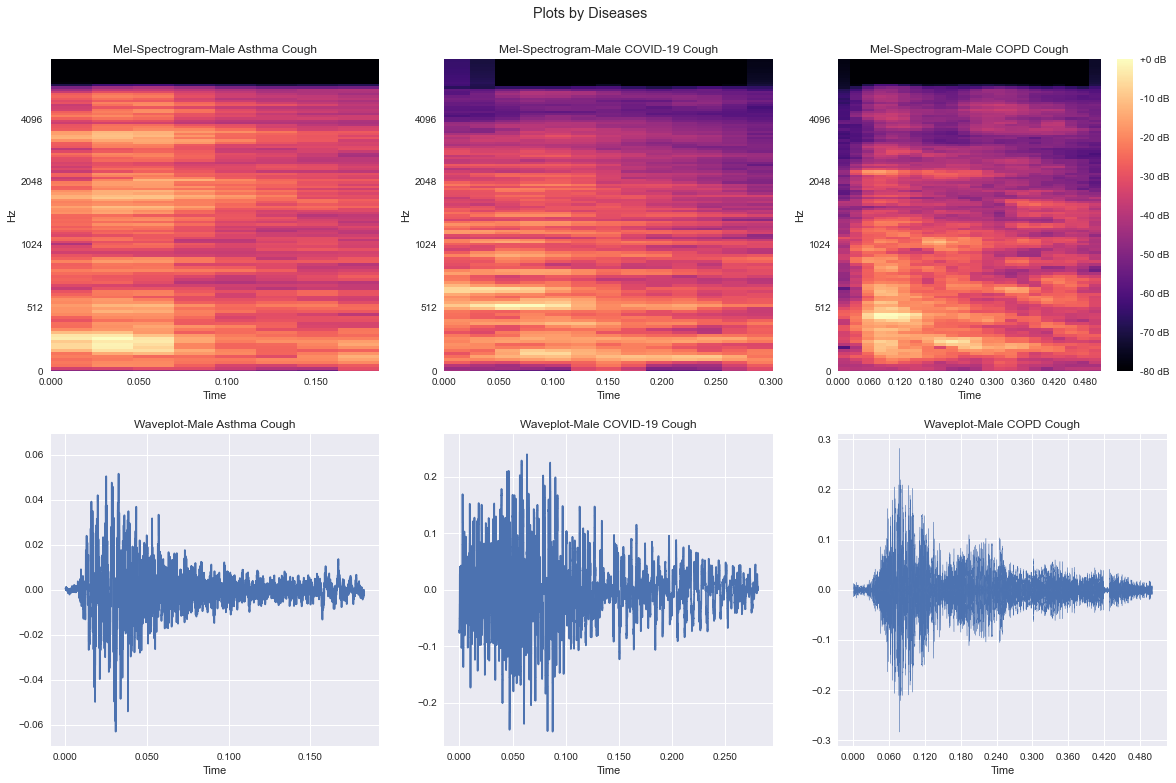

In [16]:
cough_vis = [asthma_cough, covid_cough, copd_cough]

i = 0
fig, axs = plt.subplots(2, 3, figsize=(20,12))
fig.suptitle('Plots by Diseases', fontsize="x-large")

for i, cough in enumerate(cough_vis): 

    y, sr = librosa.load(cough)
    D = np.abs(librosa.stft(y))**2 # returns STFT Coefficients in matrix form
    S = librosa.feature.melspectrogram(S=D, sr=sr) 

    S_dB = librosa.power_to_db(S, ref=np.max)
    if i == 0:
        # Mel-Spectrogram
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,0])
        axs[0,0].set(title='Mel-Spectrogram-Male Asthma Cough')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,0])
        axs[1,0].set(title='Waveplot-Male Asthma Cough')
    if i ==1:
        # Mel-Spectrogram        
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,1])
        axs[0,1].set(title='Mel-Spectrogram-Male COVID-19 Cough')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,1])
        axs[1,1].set(title='Waveplot-Male COVID-19 Cough')        
    if i ==2:
        # Mel-Spectrogram
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,2])
        axs[0,2].set(title='Mel-Spectrogram-Male COPD Cough')    
        fig.colorbar(img, ax=axs[0,2], format='%+2.0f dB')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,2])
        axs[1,2].set(title='Waveplot-Male COPD Cough')

fig.subplots_adjust(top=0.92)
plt.show()

Visualization by particular patient 

In [17]:
# Defining random cough paths for visualization
asthma_cough1 = main_data["cough_path"][main_data["disease"] == "asthma"][123]
asthma_cough2 = main_data["cough_path"][main_data["disease"] == "asthma"][125]
asthma_cough3 = main_data["cough_path"][main_data["disease"] == "asthma"][126]
print(asthma_cough1)
print(asthma_cough2)
print(asthma_cough3)

S:\annotated_new\S10 Giuliano\0523Night2Part\Export\cough19-f.wav
S:\annotated_new\S10 Giuliano\0523Night2Part\Export\cough20-f.wav
S:\annotated_new\S10 Giuliano\0523Night2Part\Export\cough21-f.wav


C:\Users\Admin\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1132
  warnings.warn(
<ipython-input-18-f9e8f32a8101>:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img, ax=axs[0,2], format='%+2.0f dB')


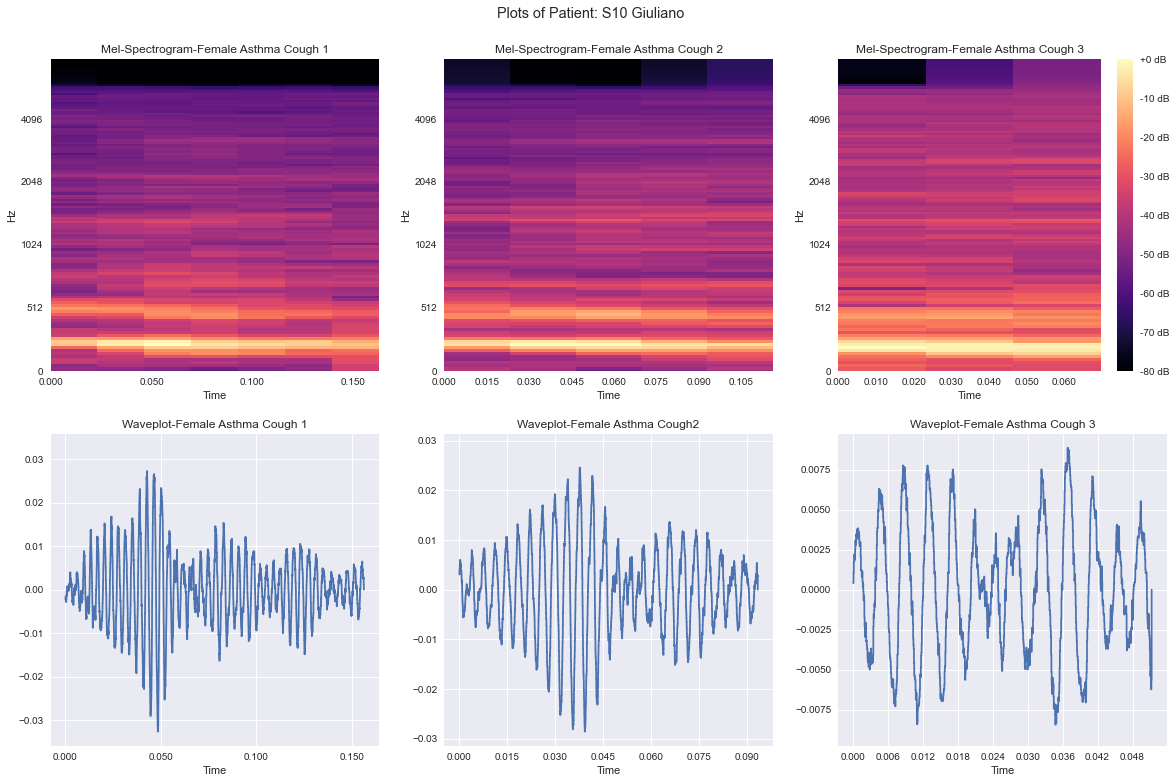

In [18]:

cough_vis = [asthma_cough1, asthma_cough2, asthma_cough3]

i = 0
fig, axs = plt.subplots(2, 3, figsize=(20,12))
fig.suptitle('Plots of Patient: S10 Giuliano', fontsize="x-large")
for i, cough in enumerate(cough_vis): 

    y, sr = librosa.load(cough)
    D = np.abs(librosa.stft(y))**2 # returns STFT Coefficients in matrix form
    S = librosa.feature.melspectrogram(S=D, sr=sr) 

    S_dB = librosa.power_to_db(S, ref=np.max)
    if i == 0:
        # Mel-Spectrogram
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,0])
        axs[0,0].set(title='Mel-Spectrogram-Female Asthma Cough 1')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,0])
        axs[1,0].set(title='Waveplot-Female Asthma Cough 1')
    if i ==1:
        # Mel-Spectrogram        
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,1])
        axs[0,1].set(title='Mel-Spectrogram-Female Asthma Cough 2')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,1])
        axs[1,1].set(title='Waveplot-Female Asthma Cough2')        
    if i ==2:
        # Mel-Spectrogram
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axs[0,2])
        axs[0,2].set(title='Mel-Spectrogram-Female Asthma Cough 3')    
        fig.colorbar(img, ax=axs[0,2], format='%+2.0f dB')
        # Waveplot
        img = librosa.display.waveshow(y, sr=sr, x_axis='time', ax=axs[1,2])
        axs[1,2].set(title='Waveplot-Female Asthma Cough 3')                
fig.subplots_adjust(top=0.92)
plt.show()

EDAA

What is the total cough amount we have? 32998
What is the total patient amount we have? 102
What is the patient distribution? OK

What is the cough gender distribution?
What is the average cough duration?
What is the cough duration distribution by disease? 

Total patients: 90
Total coughs: 27591


[Text(0.5, 1.0, 'Number of coughs per gender')]

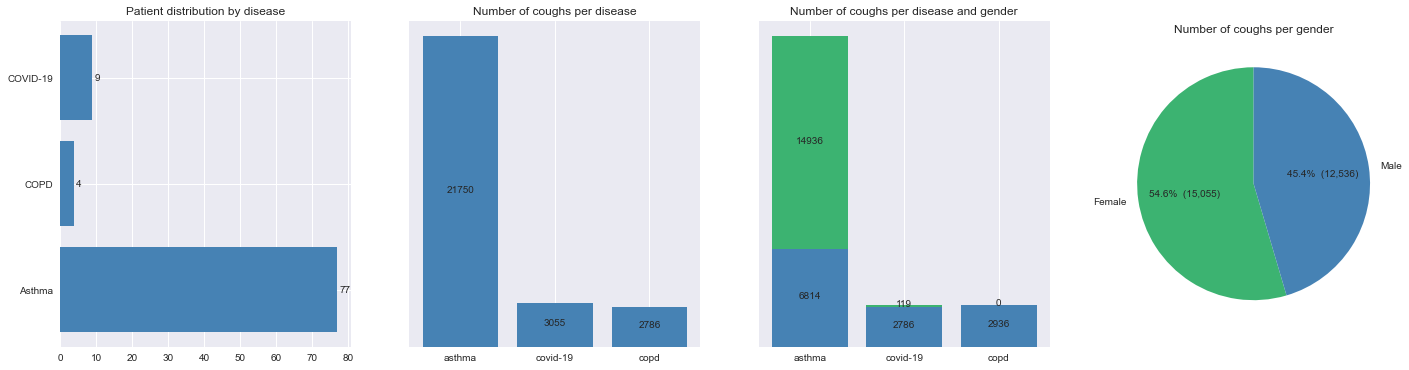

In [8]:
total_cough = main_data["cough_path"].nunique()
total_patient = main_data["patient_ID"].nunique()
#total_male_cough = main_data["cough_gender"].value_counts()


print("Total patients: %i" % total_patient)
print("Total coughs: %i" % total_cough)


fig, axs = plt.subplots(1, 4, figsize=(24,6))

patients_by_disease = main_data.groupby(["patient_ID"])["disease"].value_counts().rename_axis(['patient_ID','disease']).reset_index(name='counts')
asthma_pat = len(patients_by_disease[patients_by_disease["disease"]=="asthma"])
copd_pat = len(patients_by_disease[patients_by_disease["disease"]=="copd"])
covid_pat = len(patients_by_disease[patients_by_disease["disease"]=="covid-19"])

pat_distribution = [asthma_pat, copd_pat, covid_pat]
diseases = ["Asthma","COPD","COVID-19"]

axs[0].barh(diseases, pat_distribution, color=["steelblue"])
axs[0].set(title="Patient distribution by disease")
axs[0].bar_label(axs[0].containers[0], label_type='edge', padding=2)


bar_data = main_data["disease"].value_counts().rename_axis('disease').reset_index(name='counts')

axs[1].bar(bar_data["disease"], bar_data["counts"], color=["steelblue"])
axs[1].set(title="Number of coughs per disease")
axs[1].bar_label(axs[1].containers[0], label_type='center', padding=2)
axs[1].set(yticks=[])

bar_data2 = main_data.groupby("disease")["cough_gender"].value_counts().rename_axis(['disease','gender']).reset_index(name='counts')
bar_data21_f = bar_data2[bar_data2["gender"]=="f"]
bar_data21_m = bar_data2[bar_data2["gender"]=="m"] 
row = pd.Series({"disease":"copd", "gender":"f", "counts":0})
bar_data21_f = bar_data21_f.append(row, ignore_index=True)

axs[2].bar(bar_data["disease"], bar_data21_m["counts"], color=["steelblue"])
axs[2].bar_label(axs[2].containers[0], label_type='center', padding=2)
axs[2].bar(bar_data["disease"], bar_data21_f["counts"], bottom=bar_data21_m["counts"], color=["mediumseagreen"])
axs[2].set(title="Number of coughs per disease and gender")
axs[2].bar_label(axs[2].containers[1], label_type='center', padding=2)
axs[2].set(yticks=[])

gender_data = main_data["cough_gender"].value_counts()
labels = ['Female', 'Male']

axs[3].pie(gender_data, labels = labels, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(gender_data)/100), startangle = 90, colors=["mediumseagreen", "steelblue"])
axs[3].set(title='Number of coughs per gender')



In [7]:
bar_data2["disease"].unique()

array(['asthma', 'copd', 'covid-19'], dtype=object)

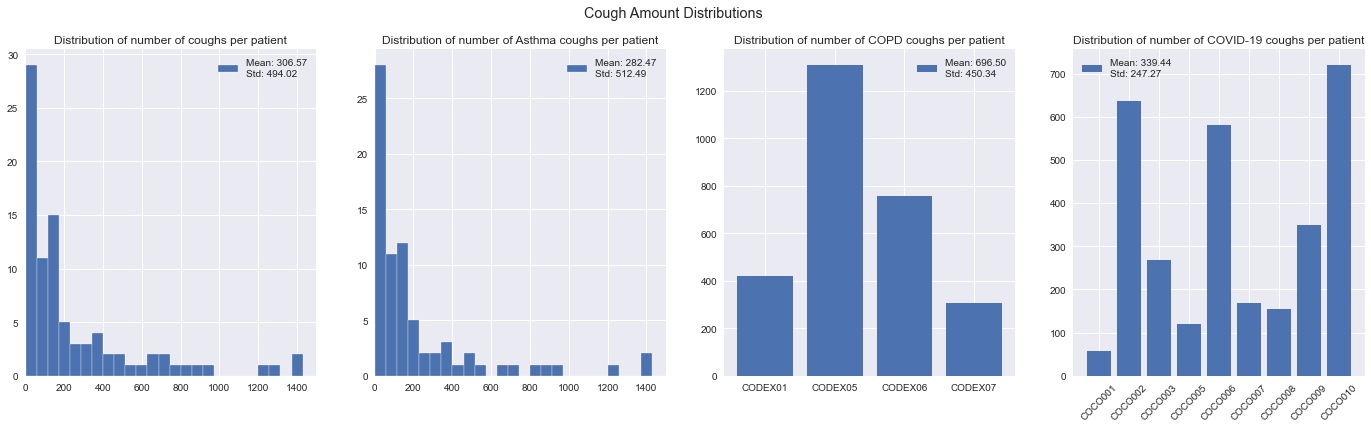

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle('Cough Amount Distributions', fontsize="x-large")

cough_number= main_data.groupby("patient_ID")["cough_gender"].value_counts().rename_axis(['patient','gender']).reset_index(name='counts')

n_bins = 60
axs[0].hist(cough_number["counts"], bins = n_bins, edgecolor='white')
axs[0].set(title="Distribution of number of coughs per patient")
legend = ['Mean: %.2f\nStd: %.2f' % (cough_number["counts"].mean(), cough_number["counts"].std())]
axs[0].legend(legend)
axs[0].set_xlim([0, 1500])


cough_number = main_data.groupby("patient_ID")["disease"].value_counts().rename_axis(['patient','disease']).reset_index(name='counts')
cough_number_asthma = cough_number[cough_number["disease"]=="asthma"]

n_bins = 60
axs[1].hist(cough_number_asthma["counts"], bins = n_bins,  edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (cough_number_asthma["counts"].mean(), cough_number_asthma["counts"].std())]
axs[1].legend(legend)
axs[1].set(title="Distribution of number of Asthma coughs per patient")
axs[1].set_xlim([0, 1500])

cough_number_copd = cough_number[cough_number["disease"]=="copd"]
axs[2].bar(cough_number_copd["patient"], cough_number_copd["counts"])
legend = ['Mean: %.2f\nStd: %.2f' % (cough_number_copd["counts"].mean(), cough_number_copd["counts"].std())]
axs[2].legend(legend)
axs[2].set(title="Distribution of number of COPD coughs per patient")

cough_number_covid = cough_number[cough_number["disease"]=="covid-19"]
axs[3].bar(cough_number_covid["patient"], cough_number_covid["counts"])
legend = ['Mean: %.2f\nStd: %.2f' % (cough_number_covid["counts"].mean(), cough_number_covid["counts"].std())]
axs[3].legend(legend)
axs[3].set(title="Distribution of number of COVID-19 coughs per patient")
#axs[3].set_xticklabels(labels, rotation=45)
axs[3].tick_params(axis='x', labelrotation=45)



(0.0, 1.75)

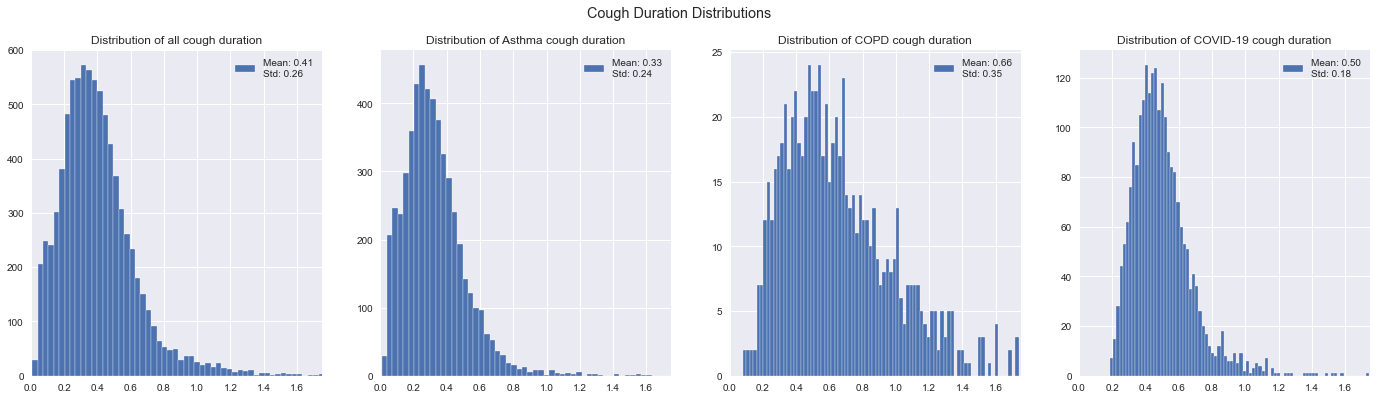

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle('Cough Duration Distributions', fontsize="x-large")
cough_duration = main_data.groupby("disease")["cough_duration"].value_counts().rename_axis(['disease','cough_duration']).reset_index(name='counts')

# All coughs
n_bins = 200
axs[0].hist(cough_duration["cough_duration"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (cough_duration["cough_duration"].mean(), cough_duration["cough_duration"].std())]
axs[0].legend(legend)
axs[0].set(title="Distribution of all cough duration")
axs[0].set_xlim([0, 1.75])

cough_duration_asthma = cough_duration[cough_duration["disease"] == "asthma"]
n_bins = 200
axs[1].hist(cough_duration_asthma["cough_duration"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (cough_duration_asthma["cough_duration"].mean(), cough_duration_asthma["cough_duration"].std())]
axs[1].legend(legend)
axs[1].set(title="Distribution of Asthma cough duration")
axs[1].set_xlim([0, 1.75])

cough_duration_copd = cough_duration[cough_duration["disease"] == "copd"]
n_bins = 100
axs[2].hist(cough_duration_copd["cough_duration"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (cough_duration_copd["cough_duration"].mean(), cough_duration_copd["cough_duration"].std())]
axs[2].legend(legend)
axs[2].set(title="Distribution of COPD cough duration")#
axs[2].set_xlim([0, 1.75])

cough_duration_covid = cough_duration[cough_duration["disease"] == "covid-19"]
n_bins = 100
axs[3].hist(cough_duration_covid["cough_duration"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (cough_duration_covid["cough_duration"].mean(), cough_duration_covid["cough_duration"].std())]
axs[3].legend(legend)
axs[3].set(title="Distribution of COVID-19 cough duration")
axs[3].set_xlim([0, 1.75])

[Text(0.5, 1.0, 'Age distribution of COVID-19 coughs')]

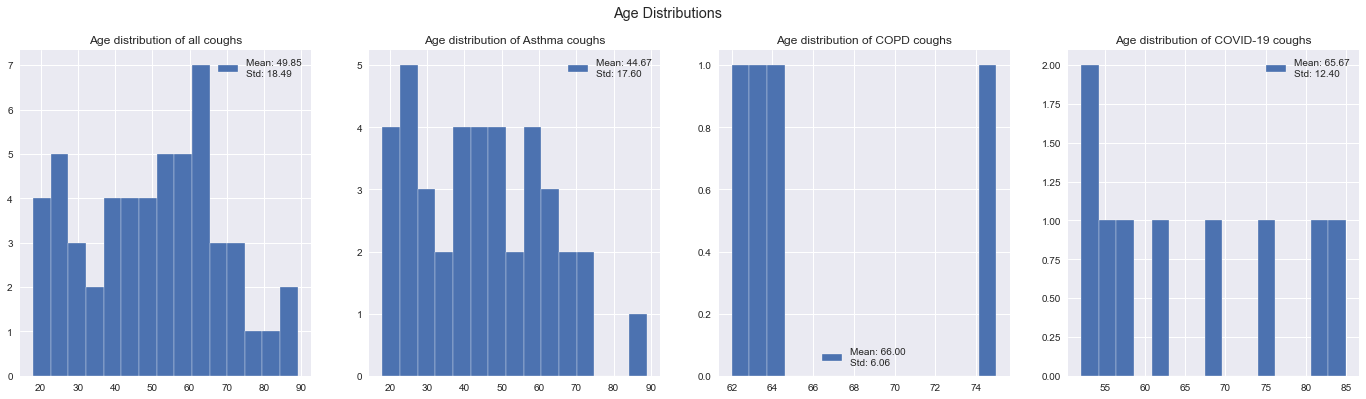

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle('Age Distributions', fontsize="x-large")
age_distribution = main_data.groupby("disease")["age"].value_counts().rename_axis(['disease','age']).reset_index(name='counts')

# All coughs
n_bins = 15
axs[0].hist(age_distribution["age"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (age_distribution["age"].mean(), age_distribution["age"].std())]
axs[0].legend(legend)
axs[0].set(title="Age distribution of all coughs")


age_asthma = age_distribution[age_distribution["disease"] == "asthma"]
n_bins = 15
axs[1].hist(age_asthma["age"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (age_asthma["age"].mean(), age_asthma["age"].std())]
axs[1].legend(legend)
axs[1].set(title="Age distribution of Asthma coughs")
# axs[1].set_xlim([0, 1.75])

age_copd = age_distribution[age_distribution["disease"] == "copd"]
n_bins = 15
axs[2].hist(age_copd["age"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (age_copd["age"].mean(), age_copd["age"].std())]
axs[2].legend(legend)
axs[2].set(title="Age distribution of COPD coughs")#
# axs[2].set_xlim([0, 1.75])

age_covid = age_distribution[age_distribution["disease"] == "covid-19"]
n_bins = 15
axs[3].hist(age_covid["age"], bins = n_bins, edgecolor='white')
legend = ['Mean: %.2f\nStd: %.2f' % (age_covid["age"].mean(), age_covid["age"].std())]
axs[3].legend(legend)
axs[3].set(title="Age distribution of COVID-19 coughs")
# axs[3].set_xlim([0, 1.75])

In [24]:
main_data.to_csv("main_data.csv", index=False)

Asthma Additional Information

In [ ]:

asthma_add = pd.read_csv("200920 - ACP_data_export_Asthma.csv")
asthma_add = asthma_add.rename(columns = {"ID":"patient_ID"})
covid_add = pd.read_csv("preprocessed_data_COVID19.csv")
covid_add = covid_add.rename(columns={"patient_name": "patient_ID"})
asthma_add

MACHINE LEARNING PART

In [131]:
main_data = pd.read_csv("main_data.csv")
main_data

,cough_path,disease,patient_ID,cough_gender,cough_duration,age,gender
0,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.070340,26.0,f
1,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.060952,26.0,f
2,S:\annotated_new\S1 Giuliano\0212Night1Part\Ex...,asthma,S1 Giuliano,f,0.058639,26.0,f
3,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.080907,26.0,f
4,S:\annotated_new\S1 Giuliano\0213Night1Part\Ex...,asthma,S1 Giuliano,f,0.076190,26.0,f
...,...,...,...,...,...,...,...
27586,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX07,m,0.499909,64.0,m
27587,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX07,m,0.491293,64.0,m
27588,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX07,m,0.414830,64.0,m
27589,C:\Users\Admin\Desktop\DATASETS\Codex\LabeledD...,copd,CODEX07,m,0.406168,64.0,m


In [132]:
cough_by_patient = main_data.groupby(["patient_ID"])["disease"].value_counts().reset_index(name='counts')
cough_by_patient


,patient_ID,disease,counts
0,COCO001,covid-19,56
1,COCO002,covid-19,637
2,COCO003,covid-19,269
3,COCO005,covid-19,119
4,COCO006,covid-19,581
...,...,...,...
85,Z47,asthma,1393
86,Z5 Giuliano,asthma,4
87,Z7 Giuliano,asthma,15
88,Z8 Giuliano,asthma,8


In [133]:
copd_patients = cough_by_patient[cough_by_patient["disease"]=="copd"]
copd_patients

,patient_ID,disease,counts
9,CODEX01,copd,419
10,CODEX05,copd,1308
11,CODEX06,copd,755
12,CODEX07,copd,304


In [134]:
covid_patients = cough_by_patient[cough_by_patient["disease"]=="covid-19"]
covid_patients

,patient_ID,disease,counts
0,COCO001,covid-19,56
1,COCO002,covid-19,637
2,COCO003,covid-19,269
3,COCO005,covid-19,119
4,COCO006,covid-19,581
5,COCO007,covid-19,168
6,COCO008,covid-19,155
7,COCO009,covid-19,350
8,COCO010,covid-19,720


In [135]:
asthma_patients = cough_by_patient[cough_by_patient["disease"]=="asthma"]
asthma_patients

,patient_ID,disease,counts
13,S1 Giuliano,asthma,62
14,S10 Giuliano,asthma,77
15,S14 Giuliano,asthma,41
16,S15 Giuliano,asthma,416
17,S16 Giuliano,asthma,222
...,...,...,...
85,Z47,asthma,1393
86,Z5 Giuliano,asthma,4
87,Z7 Giuliano,asthma,15
88,Z8 Giuliano,asthma,8


In [155]:
copd_p_index = copd_patients.index.tolist()
copd_p_index

[9, 10, 11, 12]

In [156]:
copd_p_index

[9, 10, 11, 12]

In [158]:
copd_p_index_train = sample(copd_p_index, int(len(copd_p_index)*0.8)) 
copd_p_index_train

[9, 11, 12]

In [159]:
copd_p_index_test = np.setdiff1d(copd_p_index, copd_p_index_train)
copd_p_index_test

array([10])

In [160]:
len(copd_p_index_test)

1

In [161]:
import random
from random import sample
random.seed(42)

# returns the indices of the each patient group
covid_p_index = covid_patients.index.tolist()
copd_p_index = copd_patients.index.tolist()
asthma_p_index = asthma_patients.index.tolist()

# total patient per disease
print("%i COVID-19 patients in all data." % len(covid_patients))
print("%i COPD patients in all data." % len(copd_patients))
print("%i Asthma  patients in all data." % len(asthma_patients))
print("-------------------------------------------")

# training & testing separation (80-20)

# training set patients
covid_p_index_train = sample(covid_p_index, int(len(covid_p_index)*0.8)) 
copd_p_index_train = sample(copd_p_index, int(len(copd_p_index)*0.8)) 
asthma_p_index_train = sample(asthma_p_index, int(len(asthma_p_index)*0.8)) 

print("%i COVID-19 patients in training data." % len(covid_p_index_train))
print("%i COPD patients in training data." % len(copd_p_index_train))
print("%i Asthma  patients in training data.\n" % len(asthma_p_index_train))

# test set patients
covid_p_index_test = np.setdiff1d(covid_p_index, covid_p_index_train)
copd_p_index_test = np.setdiff1d(copd_p_index, copd_p_index_train)
asthma_p_index_test = np.setdiff1d(asthma_p_index, asthma_p_index_train)

print("%i COVID-19 patients in test data." % len(covid_p_index_test))
print("%i COPD patients in test data." % len(copd_p_index_test))
print("%i Asthma  patients in test data.\n" % len(asthma_p_index_test))


9 COVID-19 patients in all data.
4 COPD patients in all data.
77 Asthma  patients in all data.
-------------------------------------------
7 COVID-19 patients in training data.
3 COPD patients in training data.
61 Asthma  patients in training data.

2 COVID-19 patients in test data.
1 COPD patients in test data.
16 Asthma  patients in test data.



In [162]:

train_covid = covid_patients[covid_patients.index.isin(covid_p_index_train)]["patient_ID"]
train_copd = copd_patients[copd_patients.index.isin(copd_p_index_train)]["patient_ID"]
train_asthma = asthma_patients[asthma_patients.index.isin(asthma_p_index_train)]["patient_ID"]

test_covid = covid_patients[covid_patients.index.isin(covid_p_index_test)]["patient_ID"]
test_copd = copd_patients[copd_patients.index.isin(copd_p_index_test)]["patient_ID"]
test_asthma = asthma_patients[asthma_patients.index.isin(asthma_p_index_test)]["patient_ID"]

# returning each observation belonging to the patients in training set per disease 
train_covid_index = main_data[main_data["patient_ID"].isin(train_covid)].index
train_copd_index = main_data[main_data["patient_ID"].isin(train_copd)].index
train_asthma_index = main_data[main_data["patient_ID"].isin(train_asthma)].index

# returning each observation belonging to the patients in test set per disease 
test_covid_index = main_data[main_data["patient_ID"].isin(test_covid)].index
test_copd_index = main_data[main_data["patient_ID"].isin(test_copd)].index
test_asthma_index = main_data[main_data["patient_ID"].isin(test_asthma)].index



In [163]:
# accumulating indices for training and test sets

training_set_indices = train_covid_index.values.tolist() + train_copd_index.values.tolist() + train_asthma_index.values.tolist()  
test_set_indices = test_covid_index.values.tolist() + test_copd_index.values.tolist() + test_asthma_index.values.tolist()  
print(len(training_set_indices))
print(len(test_set_indices))

22579
5012


In [164]:
type(test_set_indices)

list

In [165]:
# sorted indices for the feature matrix
training_set_indices = sorted(training_set_indices, reverse=False)
test_set_indices = sorted(test_set_indices, reverse=False)

In [166]:
# Training dataset patients and cough amounts
# covid_patients[covid_patients.index.isin(covid_p_index_train)]
# copd_patients[copd_patients.index.isin(copd_p_index_train)]
# asthma_patients[asthma_patients.index.isin(asthma_p_index_train)]

total_covid_train = np.sum(covid_patients[covid_patients.index.isin(covid_p_index_train)])["counts"]
total_copd_train = np.sum(copd_patients[copd_patients.index.isin(copd_p_index_train)])["counts"]
total_asthma_train = np.sum(asthma_patients[asthma_patients.index.isin(asthma_p_index_train)])["counts"]

print("%i COVID-19 coughs in training data." % (total_covid_train))
print("%i COPD coughs in training data." % (total_copd_train))
print("%i Asthma  coughs in training data." % (total_asthma_train))
print("%i Total coughs in training set.\n" % (total_covid_train + total_copd_train + total_asthma_train))

# Testing dataset patients and cough amounts
# covid_patients[covid_patients.index.isin(covid_p_index_test)]
# copd_patients[copd_patients.index.isin(copd_p_index_test)]
# asthma_patients[asthma_patients.index.isin(asthma_p_index_test)]

total_covid_test = np.sum(covid_patients[covid_patients.index.isin(covid_p_index_test)])["counts"]
total_copd_test = np.sum(copd_patients[copd_patients.index.isin(copd_p_index_test)])["counts"]
total_asthma_test = np.sum(asthma_patients[asthma_patients.index.isin(asthma_p_index_test)])["counts"]

print("%i COVID-19 coughs in test data." % (total_covid_test))
print("%i COPD coughs in test data." % (total_copd_test))
print("%i Asthma  coughs in test data." % (total_asthma_test))
print("%i Total coughs in test set.\n" % (total_covid_test + total_copd_test + total_asthma_test))


2781 COVID-19 coughs in training data.
1478 COPD coughs in training data.
18320 Asthma  coughs in training data.
22579 Total coughs in training set.

274 COVID-19 coughs in test data.
1308 COPD coughs in test data.
3430 Asthma  coughs in test data.
5012 Total coughs in test set.



In [22]:
# Mel-frequency cepstral coefficients (MFCCs)
# MFCCs
# Log-Filterbank Energies
# Zero Crossing Rate
# Kurtosis

In [ ]:
# sorted indices for the feature matrix
training_set_indices = sorted(training_set_indices, reverse=False)
test_set_indices = sorted(test_set_indices, reverse=False)

In [ ]:
test_set_indices

In [168]:

import pickle
with open('feature_matrix_new.pkl','rb') as f:
    feature_matrix_loaded = pickle.load(f)


In [172]:
feature_matrix_loaded.shape

(27591, 122)

In [173]:
# sorted indices for the feature matrix

train = np.delete(feature_matrix_loaded, test_set_indices, axis = 0)
test = np.delete(feature_matrix_loaded, training_set_indices, axis = 0)
# training_set_indices = sorted(training_set_indices, reverse=False)
# test_set_indices = sorted(test_set_indices, reverse=False)

In [180]:
# from utils import Encode_Labels
# from dataset import Dataset

# def get_labels(df):

#     #asthma_lab = dataframe["disease"][dataframe["disease"]=="asthma"]#.reset_index()#.loc[0:2000].drop("index", axis=1)
#     #copd_lab = dataframe["disease"][dataframe["disease"]=="copd"]#.reset_index()#.loc[0:2000].drop("index", axis=1)
#     #covid_lab = dataframe["disease"][dataframe["disease"]=="covid-19"]#.reset_index()#.loc[0:2000].drop("index", axis=1)

#     #labels = np.vstack((np.array(asthma_lab), np.array(copd_lab), np.array(covid_lab)))

#     labels = main_data["disease"]

#     return(labels)

# dataset = Dataset()
# df = pd.read_csv("main_data.csv")
# labels = get_labels(df)

# label_encoder = Encode_Labels(labels)
# encoded_labels = label_encoder.encode_labels()


In [184]:
# len(encoded_labels)

27591

In [186]:
# y_train = np.delete(encoded_labels, test_set_indices, axis = 0)
# y_train
# #y_test = np.delete(labels, self.train_ind, axis = 0)      

array([0, 0, 0, ..., 1, 1, 1])

In [187]:
# len(y_train)

22579